**H2O AUTOML on Employee Attrition Dataset** 

Link to the dataset - https://www.kaggle.com/datasets/jpmiller/employee-attrition-for-healthcare

**Abstract-**

1. What is the question?
2. What did you do?
3. What were the results?

We need to analyze the data to check the correlation, multicollinearity and significance between two variables. Then we'll use H2O AutoML library to train the data and predict 10 different models, finally print the best model's performance.

We need to address the following questions:

1)Is the relationship significant?

2)Are any model assumptions violated?

3)Is there any multicollinearity in the model?

4)In the multivariate models are predictor variables independent of all the other predictor variables?

5)In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

6)Does the model make sense?

7)Does regularization help?

8)Which independent variables are significant?

9)Which hyperparameters are important?

In [4]:
!pip install h2o
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

from sklearn.model_selection import train_test_split
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 MB 8.1 MB/s eta 0:00:00


In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/MitaliChouthai/Data-Science/main/watson_healthcare_modified.csv')
df.head()

,EmployeeID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1313919,41,No,Travel_Rarely,1102,Cardiology,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,1200302,49,No,Travel_Frequently,279,Maternity,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,1060315,37,Yes,Travel_Rarely,1373,Maternity,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,1272912,33,No,Travel_Frequently,1392,Maternity,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,1414939,27,No,Travel_Rarely,591,Maternity,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


In [6]:
df.isnull().sum()
one_hot = {'Yes': 1, 'No': 0, 'Y':1, 'N':0, 'Male': 0, 'Female': 1}
df.Attrition = [one_hot[item] for item in df.Attrition]
df.OverTime = [one_hot[item] for item in df.OverTime]
df.Over18 = [one_hot[item] for item in df.Over18]
df.Gender = [one_hot[item] for item in df.Gender]
print(df.Gender.head())

0    1
1    0
2    0
3    1
4    0
Name: Gender, dtype: int64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1676 non-null   int64 
 1   Age                       1676 non-null   int64 
 2   Attrition                 1676 non-null   int64 
 3   BusinessTravel            1676 non-null   object
 4   DailyRate                 1676 non-null   int64 
 5   Department                1676 non-null   object
 6   DistanceFromHome          1676 non-null   int64 
 7   Education                 1676 non-null   int64 
 8   EducationField            1676 non-null   object
 9   EmployeeCount             1676 non-null   int64 
 10  EnvironmentSatisfaction   1676 non-null   int64 
 11  Gender                    1676 non-null   int64 
 12  HourlyRate                1676 non-null   int64 
 13  JobInvolvement            1676 non-null   int64 
 14  JobLevel                

In [8]:
df_business = df.BusinessTravel.value_counts()
df_department = df.Department.value_counts()
df_education_field = df.EducationField.value_counts()
df_job_role = df.JobRole.value_counts()
df_maritalStatus = df.MaritalStatus.value_counts()
print(df_business)
print(df_department)
print(df_education_field)
print(df_job_role)
print(df_maritalStatus)

Travel_Rarely        1184
Travel_Frequently     320
Non-Travel            172
Name: BusinessTravel, dtype: int64
Maternity     796
Cardiology    531
Neurology     349
Name: Department, dtype: int64
Life Sciences       697
Medical             524
Marketing           189
Technical Degree    149
Other                88
Human Resources      29
Name: EducationField, dtype: int64
Nurse             822
Other             534
Therapist         189
Administrative    115
Admin              16
Name: JobRole, dtype: int64
Married     777
Single      522
Divorced    377
Name: MaritalStatus, dtype: int64


In [9]:
df = pd.get_dummies(df, columns = ['BusinessTravel', 'Department', 'MaritalStatus', 'EducationField'])
df = df.drop(['EmployeeCount', 'HourlyRate', 'DailyRate', 'Over18', 'StandardHours', 'JobRole'], axis = 1)
print(df.columns)

Index(['EmployeeID', 'Age', 'Attrition', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'Shift', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Cardiology',
       'Department_Maternity', 'Department_Neurology',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree'],
      dtype='obj

In [10]:
df = df.astype('int64')

df.info()

print("Attrition Count: ")
print(df.Attrition.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   EmployeeID                        1676 non-null   int64
 1   Age                               1676 non-null   int64
 2   Attrition                         1676 non-null   int64
 3   DistanceFromHome                  1676 non-null   int64
 4   Education                         1676 non-null   int64
 5   EnvironmentSatisfaction           1676 non-null   int64
 6   Gender                            1676 non-null   int64
 7   JobInvolvement                    1676 non-null   int64
 8   JobLevel                          1676 non-null   int64
 9   JobSatisfaction                   1676 non-null   int64
 10  MonthlyIncome                     1676 non-null   int64
 11  MonthlyRate                       1676 non-null   int64
 12  NumCompaniesWorked                

In [11]:
df.corr()

,EmployeeID,Age,Attrition,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobSatisfaction,...,Department_Neurology,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree
EmployeeID,1.000000,-0.039033,-0.004126,-0.031648,-0.000781,-0.005930,-0.003714,-0.062473,-0.030085,-0.007392,...,-0.018754,0.000210,-0.017187,0.018318,0.018925,-0.039792,0.001936,0.034120,0.049106,-0.035974
Age,-0.039033,1.000000,-0.239984,-0.010079,0.204655,0.008945,0.041642,0.034193,0.518333,-0.015848,...,0.105404,0.025896,0.087163,-0.117209,0.004951,0.001347,0.037258,0.004800,-0.032899,-0.028045
Attrition,-0.004126,-0.239984,1.000000,0.105580,-0.038843,-0.101278,0.020661,-0.166036,-0.207634,-0.081881,...,-0.065589,-0.091722,-0.115616,0.207201,0.036165,0.004647,0.032417,-0.044632,-0.020250,0.027923
DistanceFromHome,-0.031648,-0.010079,0.105580,1.000000,0.015937,-0.019730,-0.017960,0.010281,-0.023455,-0.004758,...,-0.110170,-0.014311,0.022965,-0.011827,-0.011466,-0.033799,0.034705,0.031988,-0.014607,-0.015442
Education,-0.000781,0.204655,-0.038843,0.015937,1.000000,-0.031925,0.025727,0.041046,0.093227,-0.003957,...,-0.005336,-0.002974,-0.003665,0.006628,0.025352,0.021791,0.059741,-0.084765,0.039488,-0.008627
EnvironmentSatisfaction,-0.005930,0.008945,-0.101278,-0.019730,-0.031925,1.000000,0.010379,-0.007220,0.008277,0.001518,...,0.028842,0.022820,-0.026605,0.008074,-0.007211,-0.026716,0.001553,-0.018245,0.061190,0.029607
Gender,-0.003714,0.041642,0.020661,-0.017960,0.025727,0.010379,1.000000,-0.019599,0.043350,-0.038347,...,-0.006535,-0.036422,-0.003226,0.036314,-0.034788,-0.009769,0.032833,0.002685,-0.019616,0.007366
JobInvolvement,-0.062473,0.034193,-0.166036,0.010281,0.041046,-0.007220,-0.019599,1.000000,-0.013660,-0.039738,...,-0.002067,0.019411,0.033053,-0.053094,-0.000149,0.001215,-0.013247,0.012857,-0.006725,-0.002984
JobLevel,-0.030085,0.518333,-0.207634,-0.023455,0.093227,0.008277,0.043350,-0.013660,1.000000,-0.012497,...,0.176474,0.030563,0.055978,-0.087837,0.016698,-0.018029,0.092139,-0.008114,-0.023746,-0.047006
JobSatisfaction,-0.007392,-0.015848,-0.081881,-0.004758,-0.003957,0.001518,-0.038347,-0.039738,-0.012497,1.000000,...,0.010926,-0.016153,-0.006441,0.021501,-0.022476,0.055009,-0.030093,-0.025726,0.009689,-0.017211


<AxesSubplot:>

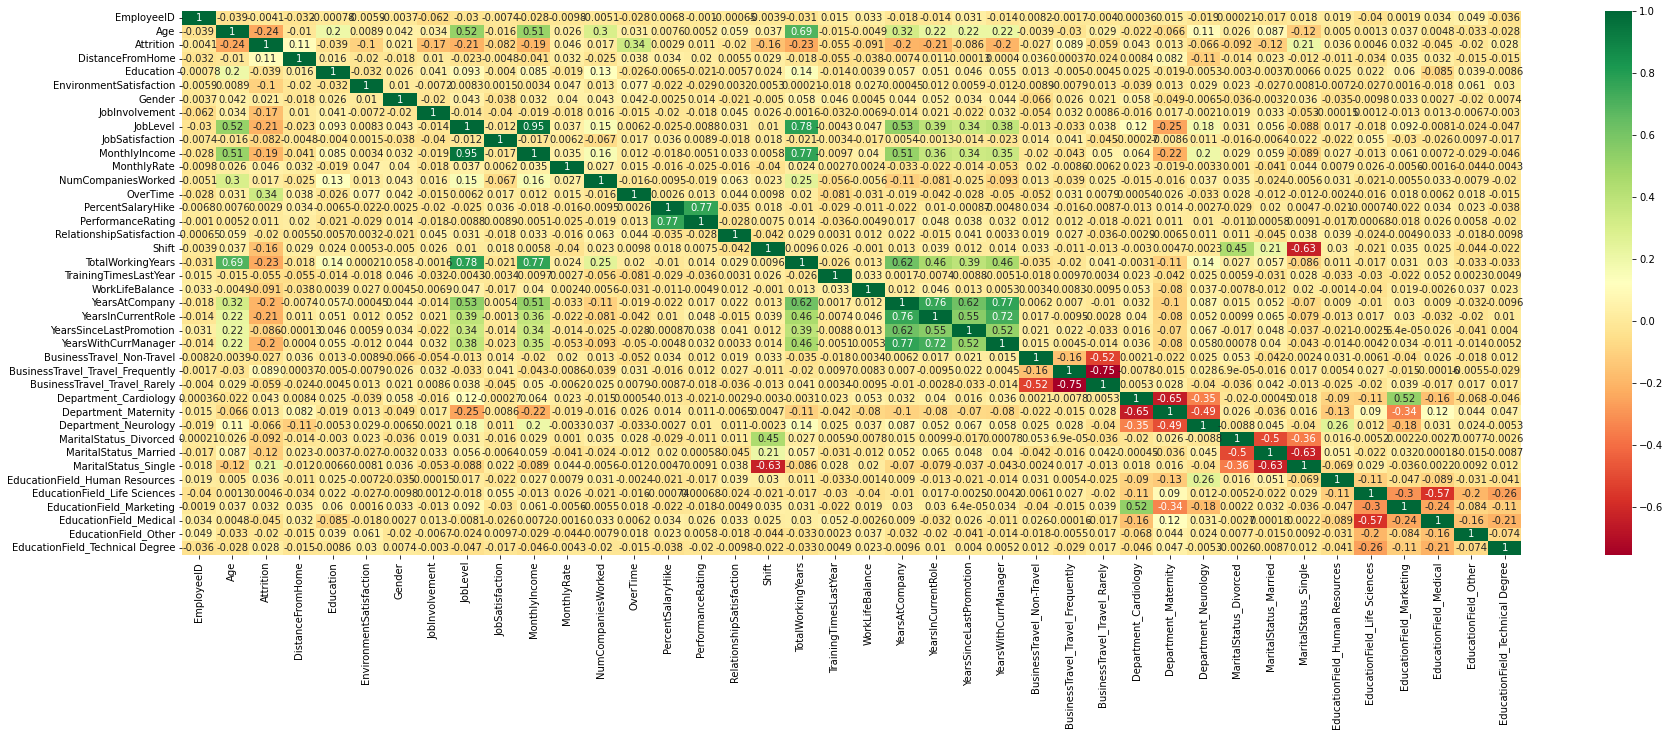

In [12]:
plt.figure(figsize=(30,10))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

<AxesSubplot:>

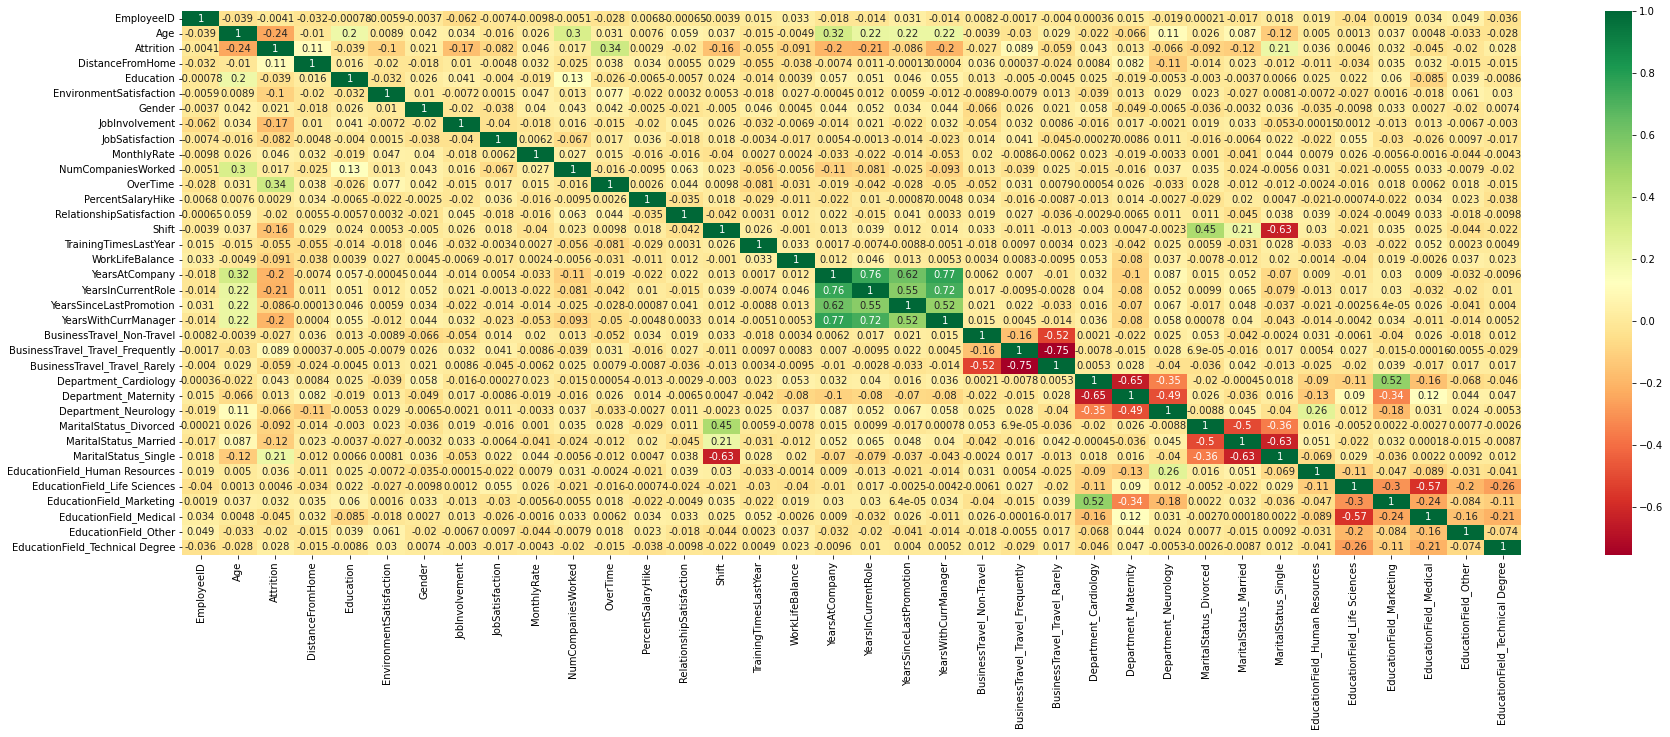

In [13]:
df = df.drop(['JobLevel', 'MonthlyIncome', 'PerformanceRating', 'TotalWorkingYears'], axis = 1)
plt.figure(figsize=(30,10))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

array([[<AxesSubplot:title={'center':'EmployeeID'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Attrition'}>,
        <AxesSubplot:title={'center':'DistanceFromHome'}>,
        <AxesSubplot:title={'center':'Education'}>,
        <AxesSubplot:title={'center':'EnvironmentSatisfaction'}>],
       [<AxesSubplot:title={'center':'Gender'}>,
        <AxesSubplot:title={'center':'JobInvolvement'}>,
        <AxesSubplot:title={'center':'JobSatisfaction'}>,
        <AxesSubplot:title={'center':'MonthlyRate'}>,
        <AxesSubplot:title={'center':'NumCompaniesWorked'}>,
        <AxesSubplot:title={'center':'OverTime'}>],
       [<AxesSubplot:title={'center':'PercentSalaryHike'}>,
        <AxesSubplot:title={'center':'RelationshipSatisfaction'}>,
        <AxesSubplot:title={'center':'Shift'}>,
        <AxesSubplot:title={'center':'TrainingTimesLastYear'}>,
        <AxesSubplot:title={'center':'WorkLifeBalance'}>,
        <AxesSubplot:title={'center':'Years

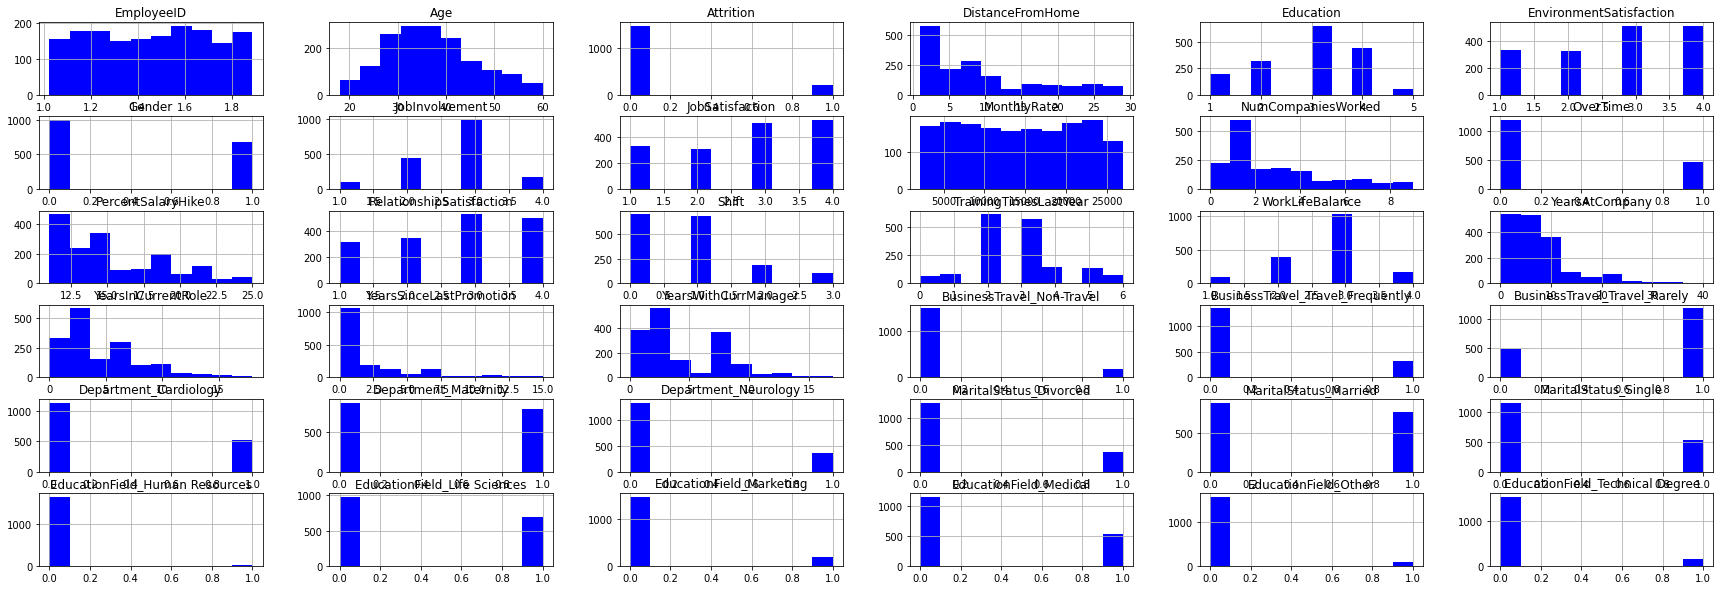

In [14]:
df.hist(color="blue", figsize=(30, 10))

                            OLS Regression Results                            
Dep. Variable:              Attrition   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.848e+28
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:11:11   Log-Likelihood:                 50755.
No. Observations:                1676   AIC:                        -1.014e+05
Df Residuals:                    1643   BIC:                        -1.013e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Employee

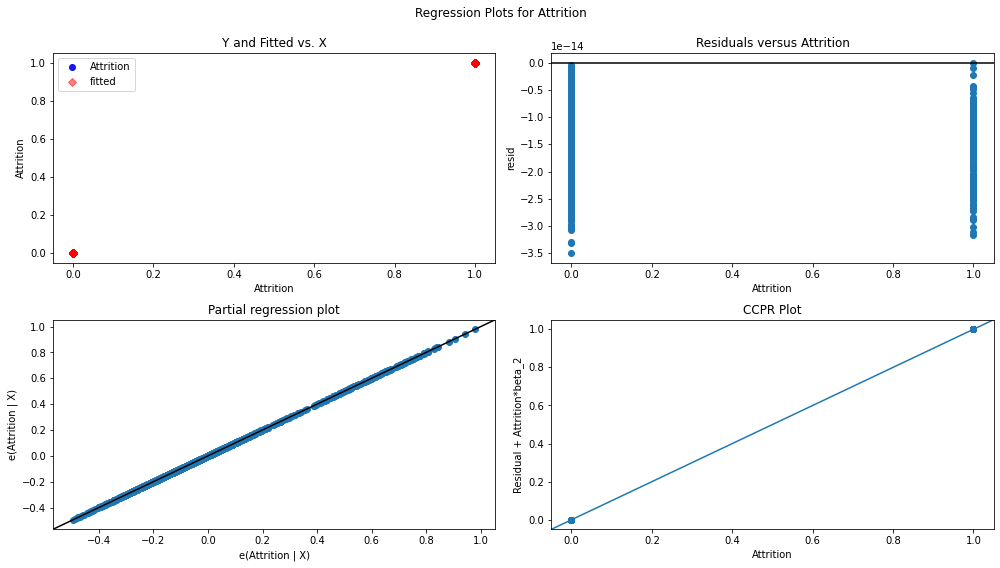

In [15]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


model = sm.OLS(df.Attrition, df).fit()
print(model.summary())

fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(model, 'Attrition', fig=fig)

Multi collinearity refers to the strong relationship or correlation between to input variables. There is said to be multi collinearity between two variables if there exist a correlation coefficient of more than 0.80. It is important to remove such variables as this leads to an inflated variance in the model which also increases the error in the model.In the heatmap it is evident that some features are highly dependent on other features. 

We can see from the above plots that some predictor variables are dependent on the others and we have dropped some

In [16]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7thrl6kv
  JVM stdout: /tmp/tmp7thrl6kv/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7thrl6kv/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_b9trhh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [17]:
data = h2o.H2OFrame(df)
data_train, data_test = data.split_frame([0.75])
print(data_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
  EmployeeID    Age    Attrition    DistanceFromHome    Education    EnvironmentSatisfaction    Gender    JobInvolvement    JobSatisfaction    MonthlyRate    NumCompaniesWorked    OverTime    PercentSalaryHike    RelationshipSatisfaction    Shift    TrainingTimesLastYear    WorkLifeBalance    YearsAtCompany    YearsInCurrentRole    YearsSinceLastPromotion    YearsWithCurrManager    BusinessTravel_Non-Travel    BusinessTravel_Travel_Frequently    BusinessTravel_Travel_Rarely    Department_Cardiology    Department_Maternity    Department_Neurology    MaritalStatus_Divorced    MaritalStatus_Married    MaritalStatus_Single    EducationField_Human Resources    EducationField_Life Sciences    EducationField_Marketing    EducationField_Medical    EducationField_Other    EducationField_Technical Degree
 1.31392e+06     41            0                   1            2                          2       

In [18]:
x = data.columns
y = 'Attrition'
x = x.remove(y)
data_train[y] = data_train[y].asfactor()
data_test[y] = data_test[y].asfactor()

aml = H2OAutoML(max_runtime_secs=222, balance_classes=True, seed=1) 
aml.train(x = x, y = y, training_frame = data_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),0/1
# DRF base models (used / total),0/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [19]:
print(aml.leaderboard)

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_BestOfFamily_4_AutoML_1_20230227_201139  0.942364   0.174218  0.745643                0.180972  0.226199  0.0511658
StackedEnsemble_BestOfFamily_2_AutoML_1_20230227_201139  0.939481   0.176207  0.744158                0.15545   0.226635  0.0513636
StackedEnsemble_AllModels_3_AutoML_1_20230227_201139     0.938758   0.178503  0.737834                0.190563  0.228339  0.0521389
StackedEnsemble_BestOfFamily_1_AutoML_1_20230227_201139  0.938318   0.177449  0.743767                0.141665  0.227544  0.0517764
StackedEnsemble_AllModels_2_AutoML_1_20230227_201139     0.937937   0.179118  0.73581                 0.158946  0.228551  0.0522356
StackedEnsemble_BestOfFamily_3_AutoML_1_20230227_201139  0.937874   0.178516  0.738638                0.153651  0.227955  0.0519634
StackedEnsemble_AllModels_1_AutoML_1_20230227_201139     0.937868   0.177953

In [20]:
model = aml.leader
model.model_performance(data_test)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.06264422928507402
RMSE: 0.25028829234519545
LogLoss: 0.20516661300514596
AUC: 0.9388943248532289
AUCPR: 0.7118397936358132
Gini: 0.8777886497064578
Null degrees of freedom: 420
Residual degrees of freedom: 417
Null deviance: 331.5812018176781
Residual deviance: 172.7502881503329
AIC: 180.7502881503329

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29035649913179357
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      343  22   0.0603   (22.0/365.0)
1      11   45   0.1964   (11.0/56.0)
Total  354  67   0.0784   (33.0/421.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290356     0.731707  66
max f2                       0.139954     0.78125   95
max f0point5                 0.424856     0.708333  45
max accuracy                 0.290356     0.921615  66
max precision                0.993441     1         0
max recall                   0.00306335   1         277
max specificity              0.993441     1         0
max absolute_mcc             0.290356     0.690024  66
max min_per_class_accuracy   0.149972     0.875     89
max mean_per_class_accuracy  0.139954     0.883415  95
max tns                      0.993441     365       0
max fns                      0.993441     55        0
max fps                      5.03865e-06  365       399
max tps                      0.00306335   56        277
max tnr                      0.993441     1         0
max fnr                      0.993441     0.982143  0
max fpr                      5.03865e-06  1         399
max tpr                      0.00306335   1         277

Gains/Lift Table: Avg response rate: 13.30 %, avg score: 12.28 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0118765                   0.916117           7.51786   7.51786            1                0.966062     1                           0.966062            0.0892857       0.0892857                  651.786   651.786            0.0892857
2        0.0213777                   0.907395           5.63839   6.68254            0.75             0.911138     0.888889                    0.941651            0.0535714       0.142857                   463.839   568.254            0.140117
3        0.0308789                   0.812334           5.63839   6.36126            0.75             0.873755     0.846154                    0.92076             0.0535714       0.196429                   463.839   536.126            0.190949
4        0.04038                     0.758025           5.63839   6.19118            0.75             0.798048     0.823529                    0.891887            0.0535714       0.25                       463.839   519.118            0.241781
5        0.0522565                   0.737425           4.51071   5.80925            0.6              0.744528     0.772727                    0.858396            0.0535714       0.303571                   351.071   480.925            0.289873
6        0.102138                    0.457813           5.3699    5.59468            0.714286         0.591608     0.744186                    0.728104            0.267857        0.571429                   436.99    459.468            0.541292
7        0.152019                    0.294097           3.57993   4.93359            0.47619          0.360056     0.65625                     0.60733

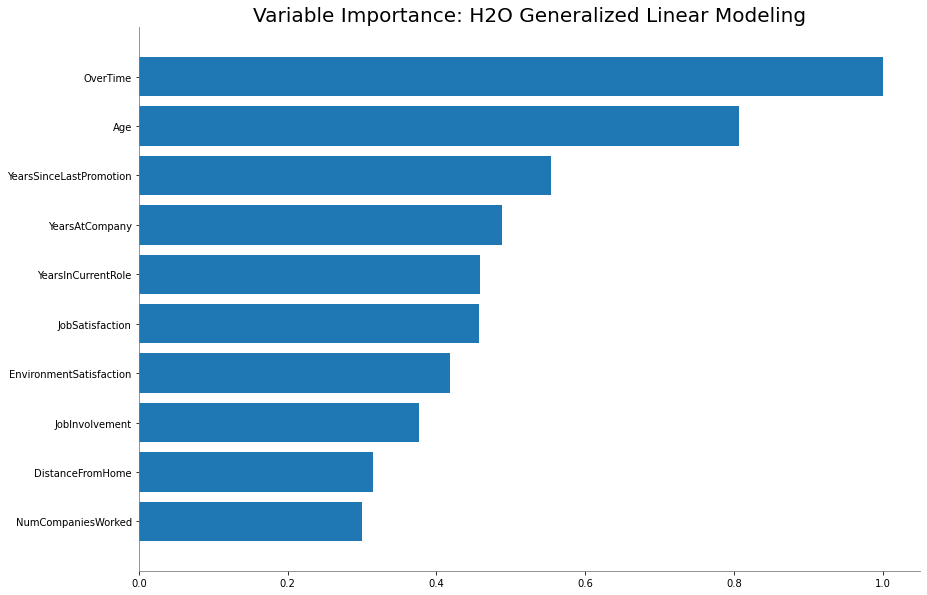

<Figure size 432x288 with 0 Axes>

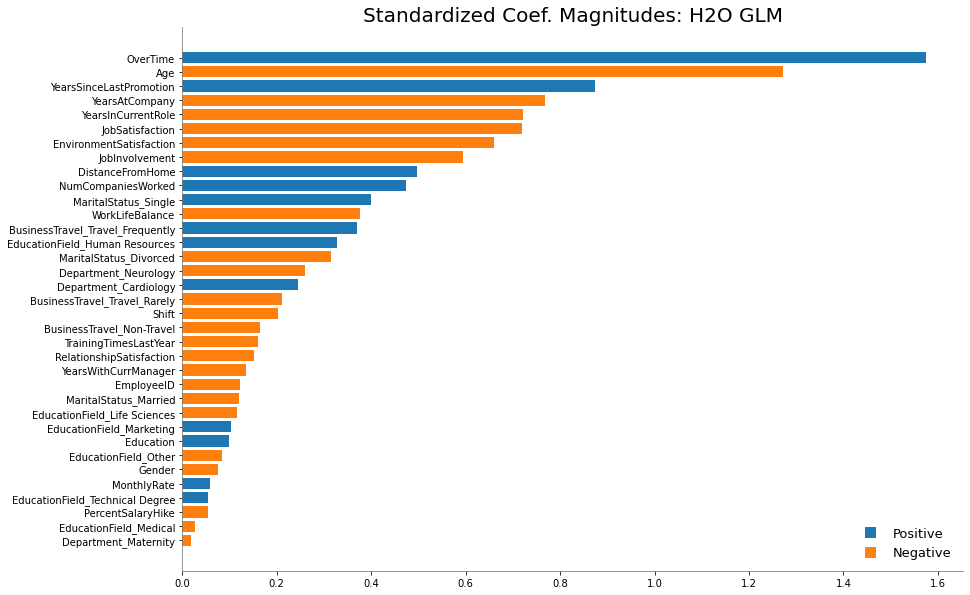

In [23]:
%matplotlib inline
model = aml.get_best_model(algorithm='glm')
model.varimp_plot()
model.std_coef_plot()

**Regularization** -
Regularization is the process of adding information in order to prevent overfitting.
We have Lasso and Ridge regularization referred to as L1 and L2 regularization.




We will build a linear and a ridge regression model and then compare the coefficients in a plot. The score of the train and test sets will also help us evaluate how well the model performs.

In [24]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
attrition_glm_default = H2OGeneralizedLinearEstimator(family="binomial", lambda_=0.05, compute_p_values=True, nfolds=5)  

attrition_glm_regularization_ridge = H2OGeneralizedLinearEstimator(family="binomial", alpha=0, nfolds=4)
attrition_glm_regularization_lasso = H2OGeneralizedLinearEstimator(family="binomial", alpha=1, nfolds=4)
attrition_glm_regularization_lamba_search = H2OGeneralizedLinearEstimator(lambda_search=True)

In [26]:
attrition_glm_default.train(x = x, y = y, training_frame=data_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Reached maximum number of iterations 5!
  warnings.warn(w)


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1677528681832_7742


GLM Model: summary
    family    link    regularization                             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  -----------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 0.05 )  35                            9                              5                       py_4_sid_9d67

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.07272186459818408
RMSE: 0.26966991785919336
LogLoss: 0.252583313494485
AUC: 0.8903192131609398
AUCPR: 0.6218146732356474
Gini: 0.7806384263218795
Null degrees of freedom: 1254
Residual degrees of freedom: 1245
Null deviance: 890.2544571974488
Residual deviance: 633.9841168711573
AIC: 653.9841168711573

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22391733760317858
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      1022  90   0.0809   (90.0/1112.0)
1      46    97   0.3217   (46.0/143.0)
Total  1068  187  0.1084   (136.0/1255.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.223917     0.587879  122
max f2                       0.175462     0.656325  161
max f0point5                 0.336791     0.638051  55
max accuracy                 0.336791     0.916335  55
max precision                0.613871     1         0
max recall                   0.0228774    1         381
max specificity              0.613871     1         0
max absolute_mcc             0.223917     0.533052  122
max min_per_class_accuracy   0.149999     0.804196  187
max mean_per_class_accuracy  0.175462     0.814471  161
max tns                      0.613871     1112      0
max fns                      0.613871     142       0
max fps                      0.00554918   1112      399
max tps                      0.0228774    143       381
max tnr                      0.613871     1         0
max fnr                      0.613871     0.993007  0
max fpr                      0.00554918   1         399
max tpr                      0.0228774    1         381

Gains/Lift Table: Avg response rate: 11.39 %, avg score: 30.01 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0103586                   0.658687           0         0                  0                0.838522  0                           0.838522            0               0                          -100      -100               -0.0116906
2        0.0207171                   0.565344           0         0                  0                0.596651  0                           0.717586            0               0                          -100      -100               -0.0233813
3        0.0302789                   0.522232           0.731352  0.230953           0.0833333        0.547011  0.0263158                   0.66372             0.00699301      0.00699301                 -26.8648  -76.9047           -0.0262804
4        0.0406375                   0.485468           0         0.172083           0                0.500184  0.0196078                   0.622035            0               0.00699301                 -100      -82.7917           -0

In [27]:
attrition_glm_regularization_ridge.train(x = x, y = y, training_frame=data_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1677528681832_7760


GLM Model: summary
    family    link    regularization               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Ridge ( lambda = 1.103E-4 )  35                            35                             6                       py_4_sid_9d67

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.04416057150138289
RMSE: 0.21014416837348326
LogLoss: 0.15339283328263126
AUC: 0.9534449363586055
AUCPR: 0.8088437024412434
Gini: 0.906889872717211
Null degrees of freedom: 1254
Residual degrees of freedom: 1219
Null deviance: 890.2544571974488
Residual deviance: 385.01601153940453
AIC: 457.01601153940453

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36545807878645553
       0     1    Error    Rate
-----  ----  ---  -------  -------------
0      1071  41   0.0369   (41.0/1112.0)
1      33    110  0.2308   (33.0/143.0)
Total  1104  151  0.059    (74.0/1255.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365458     0.748299  132
max f2                       0.252832     0.787717  155
max f0point5                 0.681012     0.781585  70
max accuracy                 0.373979     0.941036  130
max precision                0.997917     1         0
max recall                   0.00299001   1         378
max specificity              0.997917     1         0
max absolute_mcc             0.365458     0.715274  132
max min_per_class_accuracy   0.126273     0.886691  212
max mean_per_class_accuracy  0.097208     0.889247  234
max tns                      0.997917     1112      0
max fns                      0.997917     142       0
max fps                      2.84133e-05  1112      399
max tps                      0.00299001   143       378
max tnr                      0.997917     1         0
max fnr                      0.997917     0.993007  0
max fpr                      2.84133e-05  1         399
max tpr                      0.00299001   1         378

Gains/Lift Table: Avg response rate: 11.39 %, avg score: 11.39 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0103586                   0.976904           8.77622    8.77622            1                0.98959      1                           0.98959             0.0909091       0.0909091                  777.622   777.622            0.0909091
2        0.0207171                   0.933815           8.77622    8.77622            1                0.94823      1                           0.96891             0.0909091       0.181818                   777.622   777.622            0.181818
3        0.0302789                   0.894318           8.77622    8.77622            1                0.914261     1                           0.951653            0.0839161       0.265734                   777.622   777.622            0.265734
4        0.0406375                   0.822302           7.42604    8.43206            0.846154         0.862975     0.960784                    0.929048            0.0769231       0.342657                   642.604   743.206            0.340859
5        0.050

In [28]:
attrition_glm_regularization_lasso.train(x=x, y=y, training_frame=data_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1677528681832_7775


GLM Model: summary
    family    link    regularization              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  --------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Lasso (lambda = 1.103E-4 )  35                            31                             6                       py_4_sid_9d67

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.044148323194919195
RMSE: 0.21011502372490928
LogLoss: 0.15339654442510903
AUC: 0.9533537505659808
AUCPR: 0.8089719583832481
Gini: 0.9067075011319616
Null degrees of freedom: 1254
Residual degrees of freedom: 1223
Null deviance: 890.2544571974488
Residual deviance: 385.02532650702375
AIC: 449.02532650702375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36139007188511496
       0     1    Error    Rate
-----  ----  ---  -------  -------------
0      1071  41   0.0369   (41.0/1112.0)
1      33    110  0.2308   (33.0/143.0)
Total  1104  151  0.059    (74.0/1255.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36139      0.748299  134
max f2                       0.253917     0.787717  157
max f0point5                 0.68316      0.781585  70
max accuracy                 0.382673     0.941036  129
max precision                0.997885     1         0
max recall                   0.00295091   1         380
max specificity              0.997885     1         0
max absolute_mcc             0.36139      0.715274  134
max min_per_class_accuracy   0.126216     0.886691  215
max mean_per_class_accuracy  0.0969374    0.889247  238
max tns                      0.997885     1112      0
max fns                      0.997885     142       0
max fps                      2.62557e-05  1112      399
max tps                      0.00295091   143       380
max tnr                      0.997885     1         0
max fnr                      0.997885     0.993007  0
max fpr                      2.62557e-05  1         399
max tpr                      0.00295091   1         380

Gains/Lift Table: Avg response rate: 11.39 %, avg score: 11.39 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0103586                   0.976774           8.77622    8.77622            1                0.98947      1                           0.98947             0.0909091       0.0909091                  777.622   777.622            0.0909091
2        0.0207171                   0.932933           8.77622    8.77622            1                0.94793      1                           0.9687              0.0909091       0.181818                   777.622   777.622            0.181818
3        0.0302789                   0.891921           8.77622    8.77622            1                0.9139       1                           0.951395            0.0839161       0.265734                   777.622   777.622            0.265734
4        0.0406375                   0.821063           7.42604    8.43206            0.846154         0.862565     0.960784                    0.928752            0.0769231       0.342657                   642.604   743.206            0.340859
5        0.0501

In [29]:
attrition_glm_default.model_performance(data_test)

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.08774967609714532
RMSE: 0.2962257181561812
LogLoss: 0.2851587177614494
AUC: 0.8876956947162427
AUCPR: 0.5718406528617755
Gini: 0.7753913894324853
Null degrees of freedom: 420
Residual degrees of freedom: 411
Null deviance: 331.5812018176781
Residual deviance: 240.10364035514047
AIC: 260.10364035514044

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18362630161642257
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      317  48   0.1315   (48.0/365.0)
1      11   45   0.1964   (11.0/56.0)
Total  328  93   0.1401   (59.0/421.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.183626     0.604027  85
max f2                       0.150819     0.722892  100
max f0point5                 0.361305     0.530303  18
max accuracy                 0.411725     0.888361  8
max precision                0.562057     1         0
max recall                   0.0447695    1         309
max specificity              0.562057     1         0
max absolute_mcc             0.183626     0.55014   85
max min_per_class_accuracy   0.151601     0.835616  99
max mean_per_class_accuracy  0.11917      0.847847  129
max tns                      0.562057     365       0
max fns                      0.562057     55        0
max fps                      0.00620111   365       399
max tps                      0.0447695    56        309
max tnr                      0.562057     1         0
max fnr                      0.562057     0.982143  0
max fpr                      0.00620111   1         399
max tpr                      0.0447695    1         309

Gains/Lift Table: Avg response rate: 13.30 %, avg score: 30.45 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0118765                   0.821868           0         0                  0                0.850729  0                           0.850729            0               0                          -100      -100               -0.0136986
2        0.0213777                   0.685716           1.87946   0.835317           0.25             0.762538  0.111111                    0.811533            0.0178571       0.0178571                  87.9464   -16.4683           -0.00406067
3        0.0308789                   0.59115            0         0.578297           0                0.603779  0.0769231                   0.747609            0               0.0178571                  -100      -42.1703           -0.0150196
4        0.04038                     0.564714           0         0.442227           0                0.575891  0.0588235                   0.707205            0               0.0178571                  -100      -55.7773           -0.0259785
5        0.0522565                   0.512314           0         0.341721           0                0.536757  0.0454545                   0.668466            0               0.0178571                  -100      -65.8279           -0.0396771
6        0.102138                    0.409407           0.357993  0.349668           0.047619         0.444367  0.0465116                   0.559022            0.0178571       0.0357143                  -64.2007  -65.0332           -0.0766145
7        0.152019                    0.378042           1.07398   0.587333           0.142857         0.391743  0.078125                    0.504134            0.0535714    

In [30]:
attrition_glm_regularization_lasso.model_performance(data_test)

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.07338056879257224
RMSE: 0.27088848036151747
LogLoss: 0.2556867727199246
AUC: 0.910812133072407
AUCPR: 0.6438815867334866
Gini: 0.8216242661448141
Null degrees of freedom: 420
Residual degrees of freedom: 389
Null deviance: 331.5812018176781
Residual deviance: 215.28826263017666
AIC: 279.28826263017663

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29281976746380506
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      344  21   0.0575   (21.0/365.0)
1      18   38   0.3214   (18.0/56.0)
Total  362  59   0.0926   (39.0/421.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.29282      0.66087   58
max f2                       0.117874     0.756173  99
max f0point5                 0.40354      0.654762  48
max accuracy                 0.40354      0.907363  48
max precision                0.997748     1         0
max recall                   0.000239387  1         351
max specificity              0.997748     1         0
max absolute_mcc             0.29282      0.607544  58
max min_per_class_accuracy   0.117874     0.860274  99
max mean_per_class_accuracy  0.117874     0.867637  99
max tns                      0.997748     365       0
max fns                      0.997748     55        0
max fps                      1.83138e-07  365       399
max tps                      0.000239387  56        351
max tnr                      0.997748     1         0
max fnr                      0.997748     0.982143  0
max fpr                      1.83138e-07  1         399
max tpr                      0.000239387  1         351

Gains/Lift Table: Avg response rate: 13.30 %, avg score: 12.29 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0118765                   0.982447           7.51786   7.51786            1                0.992651     1                           0.992651            0.0892857       0.0892857                  651.786   651.786            0.0892857
2        0.0213777                   0.954683           5.63839   6.68254            0.75             0.971393     0.888889                    0.983203            0.0535714       0.142857                   463.839   568.254            0.140117
3        0.0308789                   0.921796           1.87946   5.20467            0.25             0.933041     0.692308                    0.967769            0.0178571       0.160714                   87.9464   420.467            0.149755
4        0.04038                     0.843828           5.63839   5.30672            0.75             0.905936     0.705882                    0.95322             0.0535714       0.214286                   463.839   430.672            0.200587
5        0.0522565                   0.758687           6.01429   5.46753            0.8              0.796066     0.727273                    0.917503            0.0714286       0.285714                   501.429   446.753            0.269276
6        0.102138                    0.496472           4.29592   4.89535            0.571429         0.61437      0.651163                    0.769462            0.214286        0.5                        329.592   389.535            0.458904
7        0.152019                    0.274068           3.93793   4.58119            0.52381          0.352957     0.609375                    0.632796           

In [31]:
attrition_glm_regularization_ridge.model_performance(data_test)

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.07329556881132845
RMSE: 0.27073154380553527
LogLoss: 0.25551379699088494
AUC: 0.910958904109589
AUCPR: 0.6446890403252025
Gini: 0.821917808219178
Null degrees of freedom: 420
Residual degrees of freedom: 385
Null deviance: 331.5812018176781
Residual deviance: 215.14261706632487
AIC: 287.1426170663249

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.296171163923409
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      345  20   0.0548   (20.0/365.0)
1      18   38   0.3214   (18.0/56.0)
Total  363  58   0.0903   (38.0/421.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.296171     0.666667  57
max f2                       0.118854     0.756173  99
max f0point5                 0.296171     0.659722  57
max accuracy                 0.296171     0.909739  57
max precision                0.997792     1         0
max recall                   0.000237069  1         352
max specificity              0.997792     1         0
max absolute_mcc             0.296171     0.614614  57
max min_per_class_accuracy   0.118854     0.860274  99
max mean_per_class_accuracy  0.118854     0.867637  99
max tns                      0.997792     365       0
max fns                      0.997792     55        0
max fps                      1.8597e-07   365       399
max tps                      0.000237069  56        352
max tnr                      0.997792     1         0
max fnr                      0.997792     0.982143  0
max fpr                      1.8597e-07   1         399
max tpr                      0.000237069  1         352

Gains/Lift Table: Avg response rate: 13.30 %, avg score: 12.29 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0118765                   0.982795           7.51786   7.51786            1                0.992756     1                           0.992756            0.0892857       0.0892857                  651.786   651.786            0.0892857
2        0.0213777                   0.95489            5.63839   6.68254            0.75             0.971316     0.888889                    0.983227            0.0535714       0.142857                   463.839   568.254            0.140117
3        0.0308789                   0.921285           1.87946   5.20467            0.25             0.933153     0.692308                    0.96782             0.0178571       0.160714                   87.9464   420.467            0.149755
4        0.04038                     0.843418           5.63839   5.30672            0.75             0.905157     0.705882                    0.953076            0.0535714       0.214286                   463.839   430.672            0.200587
5        0.0522565                   0.761689           6.01429   5.46753            0.8              0.798138     0.727273                    0.917863            0.0714286       0.285714                   501.429   446.753            0.269276
6        0.102138                    0.490762           4.29592   4.89535            0.571429         0.614546     0.651163                    0.769731            0.214286        0.5                        329.592   389.535            0.458904
7        0.152019                    0.271673           3.93793   4.58119            0.52381          0.353578     0.609375                    0.633181            0.

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GLM_1_AutoML_1_20230227_201139

,0,1,Error,Rate
0,347.0,18.0,0.0493,(18.0/365.0)
1,19.0,37.0,0.3393,(19.0/56.0)
Total,366.0,55.0,0.0879,(37.0/421.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

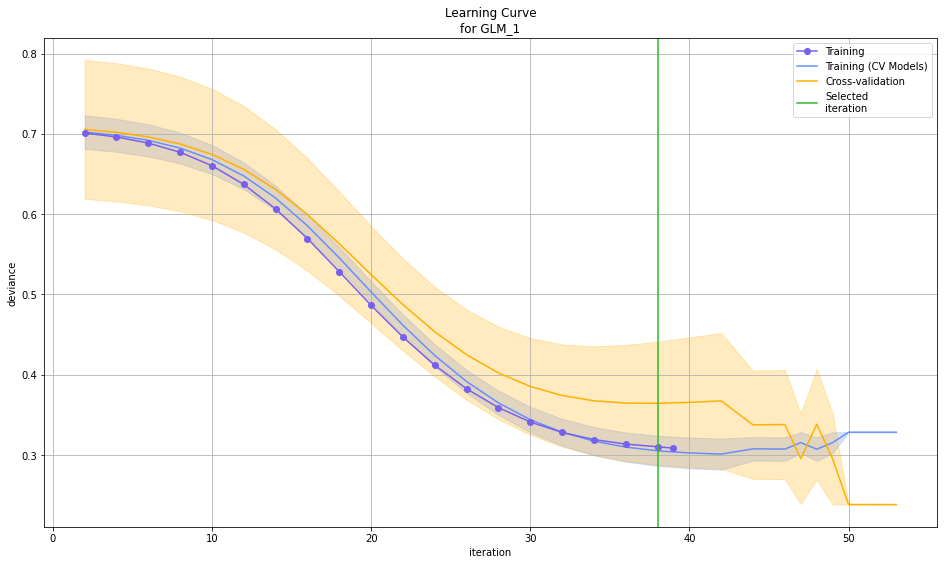

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

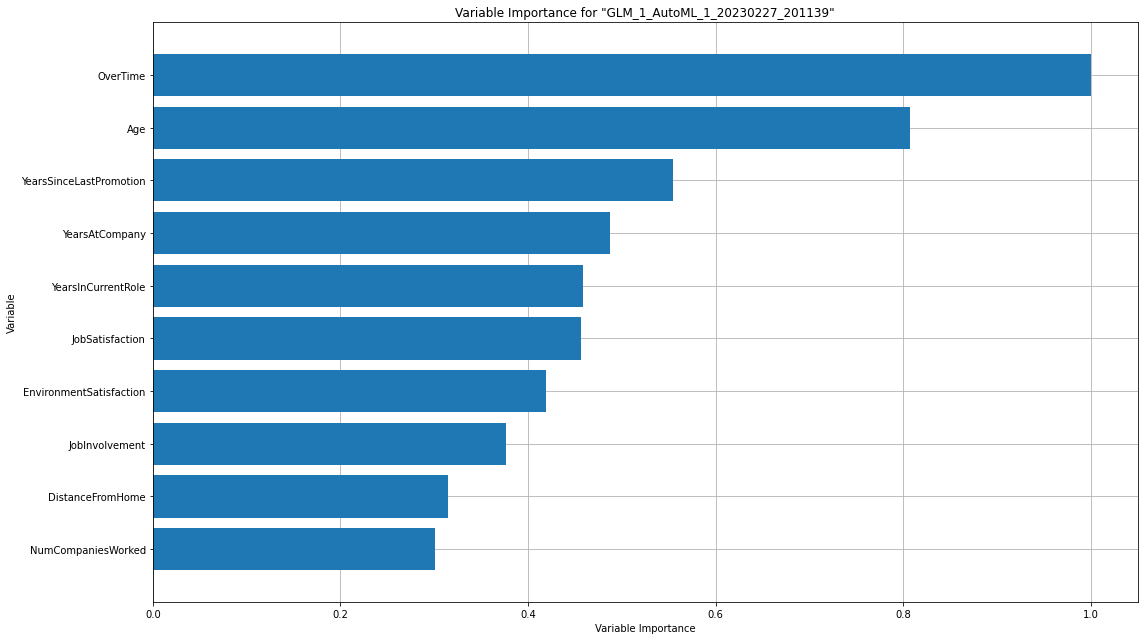

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

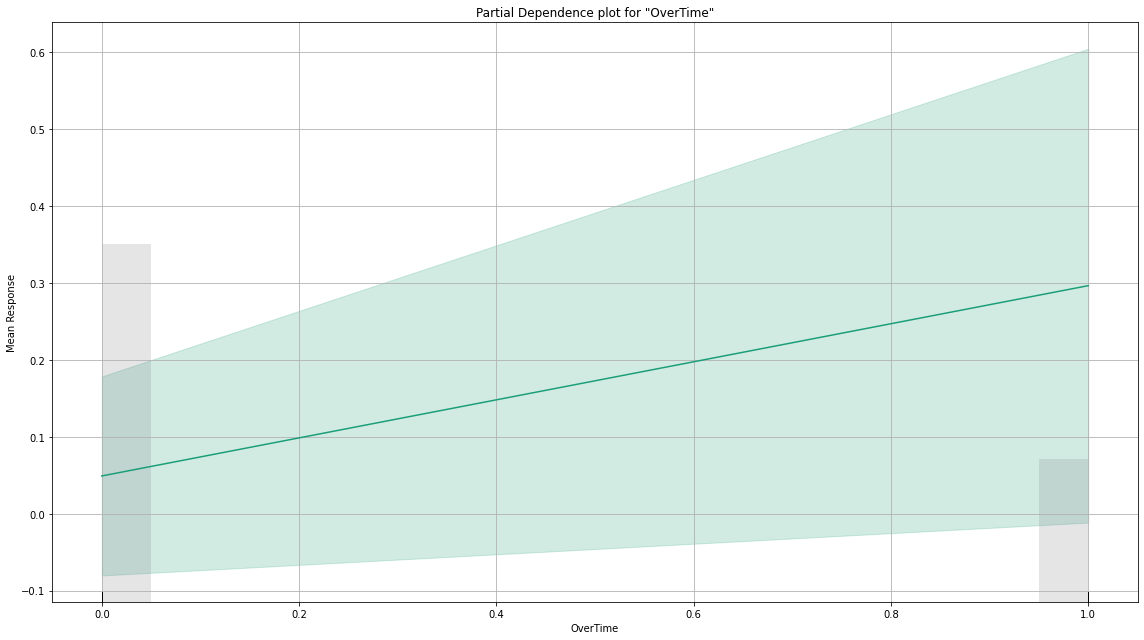

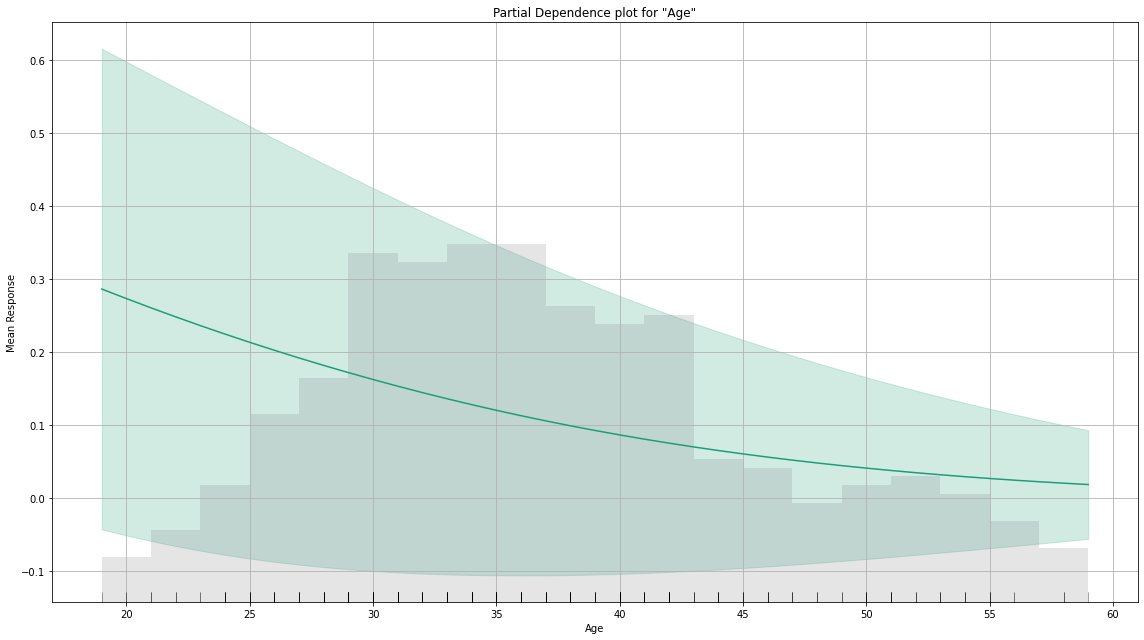

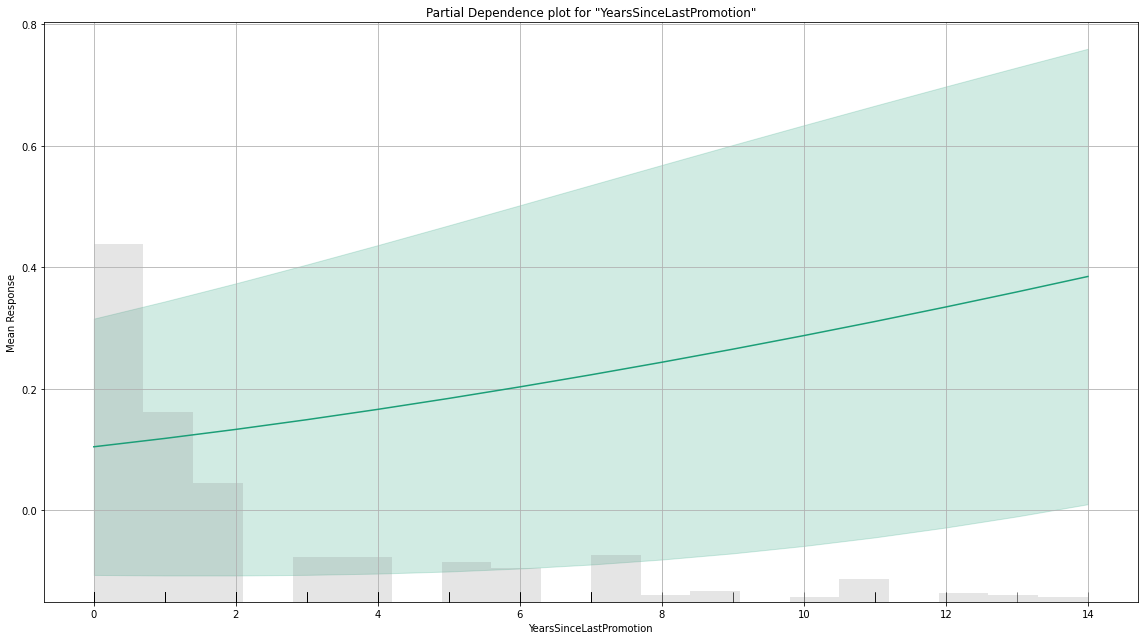

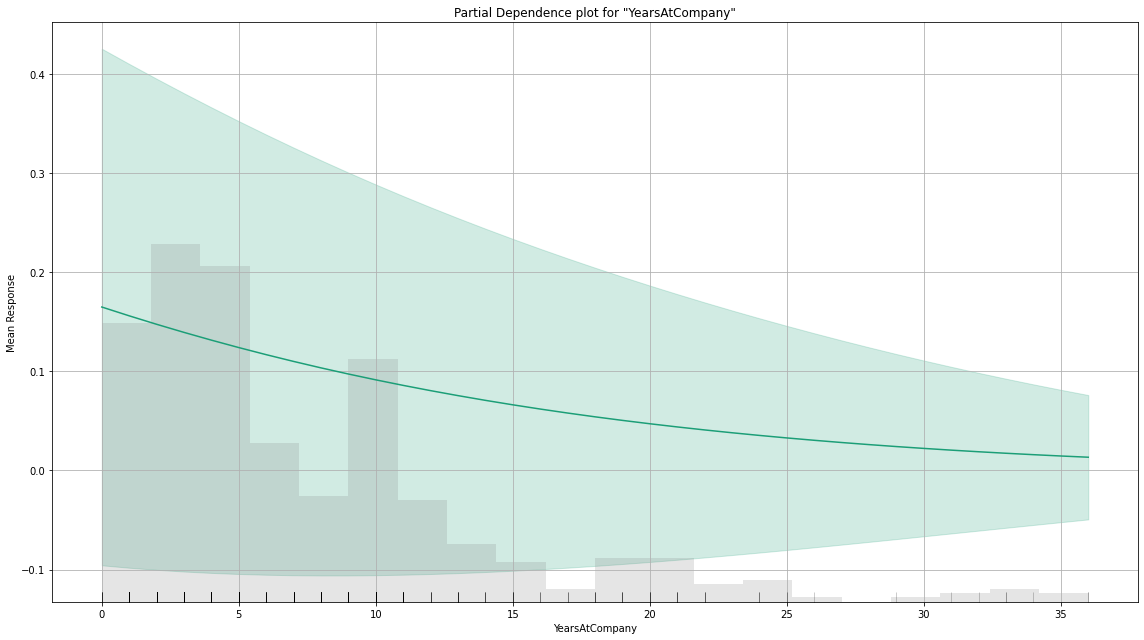

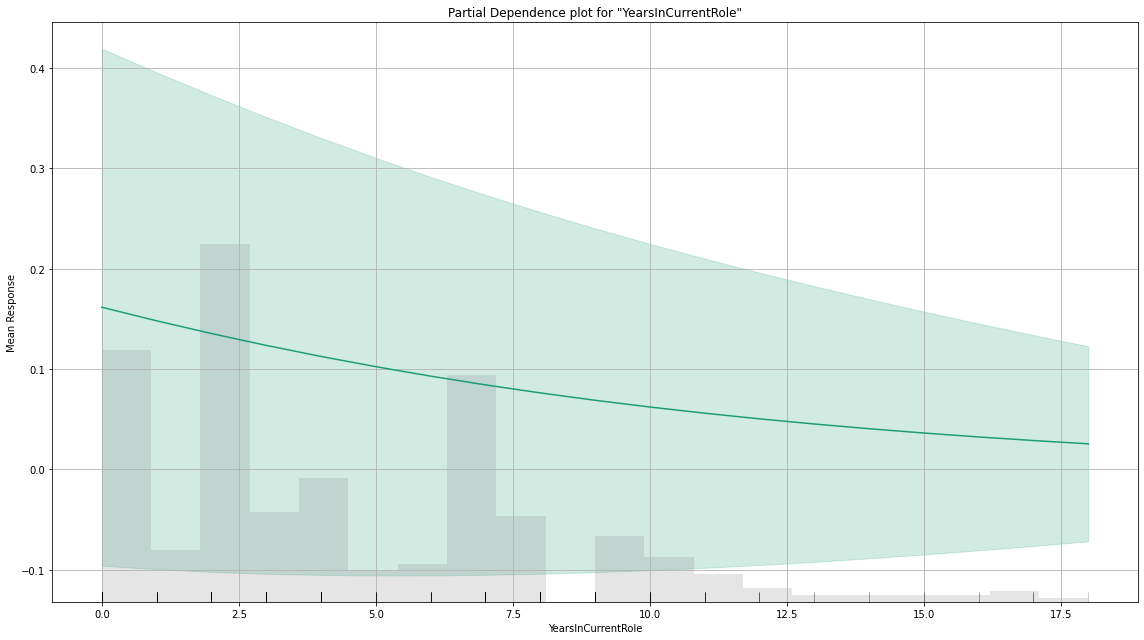

In [32]:
model_to_explain = aml.get_best_model(algorithm='glm')
explain = model_to_explain.explain(data_test)

**Hyperparameter Tuning** -
Is important to help us estimate the model parameters.

In [33]:
glm_parameters = {
    "learn_rate": [i * 0.01 for i in range(1, 11)],
    "max_depth": list(range(2, 11)),
    "sample_rate": [i * 0.1 for i in range(5, 11)],
    "col_sample_rate": [i * 0.1 for i in range(1, 11)],
}

search_criteria = {"strategy": "RandomDiscrete", "max_models": 30, "seed": 1}
glm_grid = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id="gbm_grid_search",
    hyper_params=glm_parameters,
    search_criteria=search_criteria,
)

glm_grid.train(x=x, y=y, training_frame=data_train, ntrees=100, seed=1)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,logloss
,0.5,0.1,9.0,1.0,gbm_grid_search_model_7,0.0019780
,0.9,0.09,9.0,0.6000000,gbm_grid_search_model_3,0.0109945
,0.4,0.08,6.0,0.9,gbm_grid_search_model_28,0.0174896
,0.8,0.06,9.0,0.6000000,gbm_grid_search_model_30,0.0283691
,0.5,0.05,7.0,0.9,gbm_grid_search_model_2,0.0293241
,0.9,0.1,4.0,0.7000000,gbm_grid_search_model_15,0.0378100
,0.6000000,0.1,4.0,1.0,gbm_grid_search_model_22,0.0395386
,0.1,0.07,7.0,0.8,gbm_grid_search_model_9,0.0407295
,0.7000000,0.06,5.0,0.6000000,gbm_grid_search_model_14,0.0502132
,0.8,0.03,9.0,0.9,gbm_grid_search_model_8,0.0521407


In [34]:
gbm_gridperf2 = glm_grid.get_grid(sort_by="auc", decreasing = True)
print(gbm_gridperf2)

Hyper-Parameter Search Summary: ordered by decreasing auc
     col_sample_rate      learn_rate    max_depth    sample_rate         model_ids                 auc
---  -------------------  ------------  -----------  ------------------  ------------------------  ------------------
     0.5                  0.05          7.0          0.9                 gbm_grid_search_model_2   1.0
     0.4                  0.08          6.0          0.9                 gbm_grid_search_model_28  1.0
     0.9                  0.09          9.0          0.6000000000000001  gbm_grid_search_model_3   1.0
     0.5                  0.1           9.0          1.0                 gbm_grid_search_model_7   1.0
     0.8                  0.03          9.0          0.9                 gbm_grid_search_model_8   1.0
     0.8                  0.06          9.0          0.6000000000000001  gbm_grid_search_model_30  0.9999937113246465
     0.1                  0.07          7.0          0.8                 gbm_grid_search

Q1 Is the relationship significant?
-> Yes , the relationship is significant, if we see the OLs summary -> the values that we see for the output variable and the respective predictor variables as they have high correlation value, we can assume the relationship is significant

Q2- Are any model assumptions violated? -> no, the model is a multiclassification which make sense to all models in AutoML

Q3- Is there any multicollinearity in the model? -> 

ANS- YES

Multi collinearity refers to the strong relationship or correlation between to input variables. There is said to be multi collinearity between two variables if there exist a correlation coefficient of more than 0.80. It is important to remove such variables as this leads to an inflated variance in the model which also increases the error in the model.In the heatmap it is evident that some features are highly dependent on other features.

Q4- In the multivariate models are predictor variables independent of all the other predictor variables? ->

NO

We can see from the above plots that some predictor variables are dependent on the others and we have dropped some(OLS, correlation and the heatmap)

Q5- In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model. - Done

Q6 - Does the model make sense? -Yes the model makes sense. 
the question is a multiclassfication question and models in AutoML can deal with it. 

Q7- Does regularization help? -> Yes

Regularization techniques are designed to reduce the complexity of a model, thereby reducing the risk of overfitting and improving its generalization performance.
We can see improvement in MSE and RMSE across the lasso and ridge regularization,though both methods do not have a significant difference. We can conclude that any of the regularization techniques will help for a linear model


Q8 - Which independent variables are significant - 

**Overtime**

Attrition is the target variable, and it is quite evident from the plots that attrition is dependent on overtime

Q9- Which hyperparameters are important?

all hyperparameters are important because they determined the way model works, however, there are some more important one, such as booster,max_depth, ntrees in XGBOOST 



**LICENSE**

MIT License

Copyright (c) 2023 Mitali Chouthai

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.